In [1]:
import pandas as pd
import numpy as np
import pdb, argparse
import os, pdb, math, itertools
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from ultron.factor.genetic.geneticist.operators import *
from lib.lsx001 import fetch_data1, create_factors, fetch_chosen_factors, fetch_times
from kdutils.macro2 import *

In [3]:
method = 'cicso0'
instruments = 'ims'
period = 5

In [4]:
time_array = fetch_times(method=method, instruments=instruments)
dirs = os.path.join(base_path, method, instruments, 'temp', "tree",
                        str(period))
filename = os.path.join(dirs, "final_data.feather")

./records/cicso0/ims/level2/train_data.feather
./records/cicso0/ims/returns/train_returns.feather
./records/cicso0/ims/level2/val_data.feather
./records/cicso0/ims/returns/val_returns.feather
./records/cicso0/ims/level2/test_data.feather
./records/cicso0/ims/returns/test_returns.feather


In [10]:
final_data = pd.read_feather(filename).set_index(['trade_time'])

In [15]:
train_data = final_data.loc[
    time_array['train_time'][0]:time_array['val_time'][1]]
train_data.head()

,code,"DELTA(4,MMASSI(2,'mid_price_bias_ratio',MSUM(3,'corr_money_ret')))","DELTA(3,DELTA(3,'twap'))","MMedian(2,MDPO(4,MT3(3,'pct_change')))","DELTA(3,DELTA(3,'mid_price_bias_ratio'))","MT3(2,EMA(2,MT3(2,MCPS(2,MT3(2,EMA(2,DIFF('twap')))))))","MDIFF(4,DIFF(MDEMA(4,MINIMUM('mid_price_bias_ratio','pct_change_set'))))","MMedian(2,MADiff(4,MMedian(2,MADiff(4,MDIFF(3,'pct_change_set')))))","DELTA(3,MADecay(2,DELTA(3,'pct_change_set')))","DELTA(3,DELTA(3,'pct_change_set'))","MADiff(4,MMedian(2,MADiff(4,'pct_change_set')))","MDEMA(2,MCPS(3,MCPS(3,MDEMA(4,'pct_change_close'))))","MDEMA(2,MCPS(3,MDEMA(4,'pct_change_close')))",nxt1_ret_5h
trade_time,,,,,,,,,,,,,,
2022-07-25 09:32:00,IM,NaN,NaN,-0.000172,NaN,-0.061951,-0.002887,-0.000081,NaN,NaN,-0.000162,-0.001527,-0.001527,0.002744
2022-07-25 09:33:00,IM,NaN,NaN,-0.000356,NaN,-0.396950,-0.001970,-0.000319,NaN,NaN,-0.000477,-0.003225,-0.003225,0.003311
2022-07-25 09:34:00,IM,NaN,NaN,-0.000325,NaN,-0.945056,-0.000853,-0.000516,NaN,NaN,-0.000555,-0.000294,-0.002592,0.001704
2022-07-25 09:35:00,IM,-0.555755,NaN,-0.000124,NaN,-1.682426,-0.000596,-0.000482,NaN,NaN,-0.000410,0.001685,-0.001733,0.000182
2022-07-25 09:36:00,IM,-0.184974,NaN,0.000063,NaN,-2.268532,-0.000724,-0.000327,NaN,NaN,-0.000245,0.000792,-0.001703,-0.002322


In [12]:
features = [
        col for col in final_data.columns
        if col not in ['nxt1_ret_{0}h'.format(period)]
    ]
new_columns = ["f{0}".format(i) for i in range(0, len(features))]
X_train_scaled = train_data[features]
#X_train_scaled.columns = new_columns
y_transformed = train_data['nxt1_ret_{0}h'.format(period)]

X_train, X_val, y_train, y_val = train_test_split(X_train_scaled,
                                                      y_transformed,
                                                      test_size=0.2,
                                                      shuffle=False)


In [13]:
split_point = X_train.index[-1]

plt.figure(figsize=(15, 8))

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

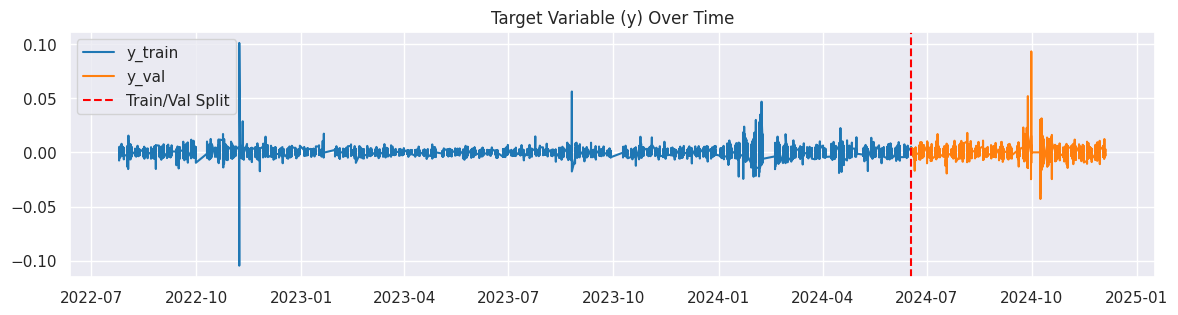

In [14]:
# 绘制目标变量 y
plt.subplot(2, 1, 1)
plt.plot(y_train, label='y_train')
plt.plot(y_val, label='y_val')
plt.axvline(split_point, color='red', linestyle='--', label='Train/Val Split')
plt.title('Target Variable (y) Over Time')
plt.legend()


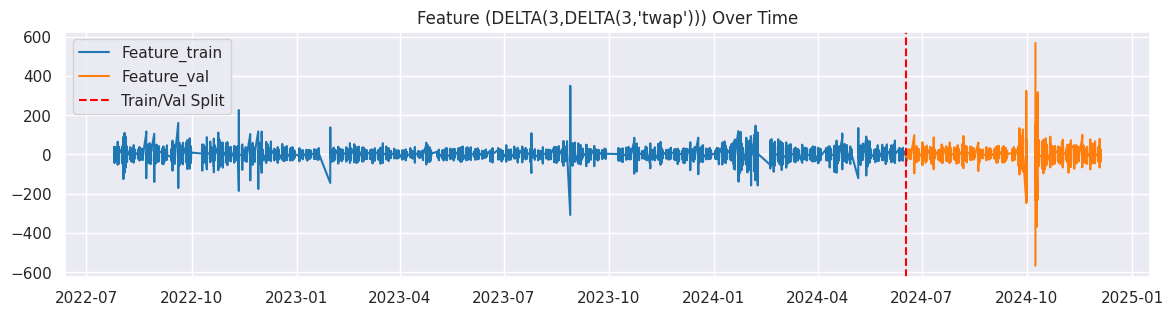

In [16]:
# 绘制一个关键特征
# 假设 'feature_name' 是你最重要的一个特征的列名
key_feature = "DELTA(3,DELTA(3,'twap'))" # 换成你的特征名
plt.subplot(2, 1, 2)
plt.plot(X_train[key_feature], label='Feature_train')
plt.plot(X_val[key_feature], label='Feature_val')
plt.axvline(split_point, color='red', linestyle='--', label='Train/Val Split')
plt.title(f'Feature ({key_feature}) Over Time')
plt.legend()
